In [1]:
import os
import numpy as np
import cuml # for fast UMAP creation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
source_val_embs = np.load('dann_embeddings/source_val_embs.npz')
blind_test_embs = np.load('dann_embeddings/blind_test_embs.npz')
result_test = pd.read_csv('results_dann_adaptation_to_blind_test_aug/blind_test_predictions.csv')

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
source_embs = source_val_embs['embeddings']
source_names = source_val_embs['filenames']
source_scores = source_val_embs['scores']
source_scores = sigmoid(source_scores)

blind_embs = blind_test_embs['embeddings']
blind_names = blind_test_embs['filenames']
blind_scores = blind_test_embs['scores']
blind_scores = sigmoid(blind_scores)

In [5]:
source_labels = np.array([1 if '_sl_' in name else 0 for name in source_names])

blind_labels = result_test[result_test['filename'].isin(blind_names)]['prediction'].values

In [6]:
all_embs = np.concatenate([source_embs, blind_embs], axis=0)
all_labels = np.concatenate([source_labels, blind_labels], axis=0)
all_scores = np.concatenate([source_scores, blind_scores], axis=0)
all_names = np.concatenate([source_names, blind_names], axis=0)

In [7]:
umap = cuml.UMAP(n_components=2, random_state=42)
all_embs_umap = umap.fit_transform(all_embs)

[2026-01-16 10:12:11.368] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [8]:
num = 20000

source_embs_umap = all_embs_umap[:num]
blind_embs_umap = all_embs_umap[num:]

source_labels = all_labels[:num]
blind_labels = all_labels[num:]

idx_sl_source = np.where(source_labels == 1)[0]
idx_nosl_source = np.where(source_labels == 0)[0]

idx_sl_blind = np.where(blind_labels == 1)[0]
idx_nosl_blind = np.where(blind_labels == 0)[0]

source_embs_sl = source_embs_umap[idx_sl_source]
source_scores_sl = source_scores[idx_sl_source]
source_embs_nosl = source_embs_umap[idx_nosl_source]
source_scores_nosl = source_scores[idx_nosl_source]

blind_embs_sl = blind_embs_umap[idx_sl_blind]
blind_scores_sl = blind_scores[idx_sl_blind]
blind_embs_nosl = blind_embs_umap[idx_nosl_blind]
blind_scores_nosl = blind_scores[idx_nosl_blind]

In [9]:
np.savez_compressed('dann_embeddings/umap_embeddings.npz', 
                    source_embs_sl=source_embs_sl,
                    source_scores_sl=source_scores_sl,
                    source_embs_nosl=source_embs_nosl,
                    source_scores_nosl=source_scores_nosl,
                    blind_embs_sl=blind_embs_sl,
                    blind_scores_sl=blind_scores_sl,
                    blind_embs_nosl=blind_embs_nosl,
                    blind_scores_nosl=blind_scores_nosl)

In [10]:
umap_emb = np.load('dann_embeddings/umap_embeddings.npz')

In [11]:
source_embs_sl = umap_emb['source_embs_sl']
source_scores_sl = umap_emb['source_scores_sl']
source_embs_nosl = umap_emb['source_embs_nosl']
source_scores_nosl = umap_emb['source_scores_nosl']
blind_embs_sl = umap_emb['blind_embs_sl']
blind_scores_sl = umap_emb['blind_scores_sl']
blind_embs_nosl = umap_emb['blind_embs_nosl']
blind_scores_nosl = umap_emb['blind_scores_nosl']

In [12]:
idx_sl_low = np.where((source_scores_sl < 0.9))[0]
idx_nosl_high = np.where((source_scores_nosl > 0.1))[0]

In [13]:
idx_sl_low_blind = np.where((blind_scores_sl < 0.9))[0]
idx_nosl_high_blind = np.where((blind_scores_nosl > 0.1))[0]

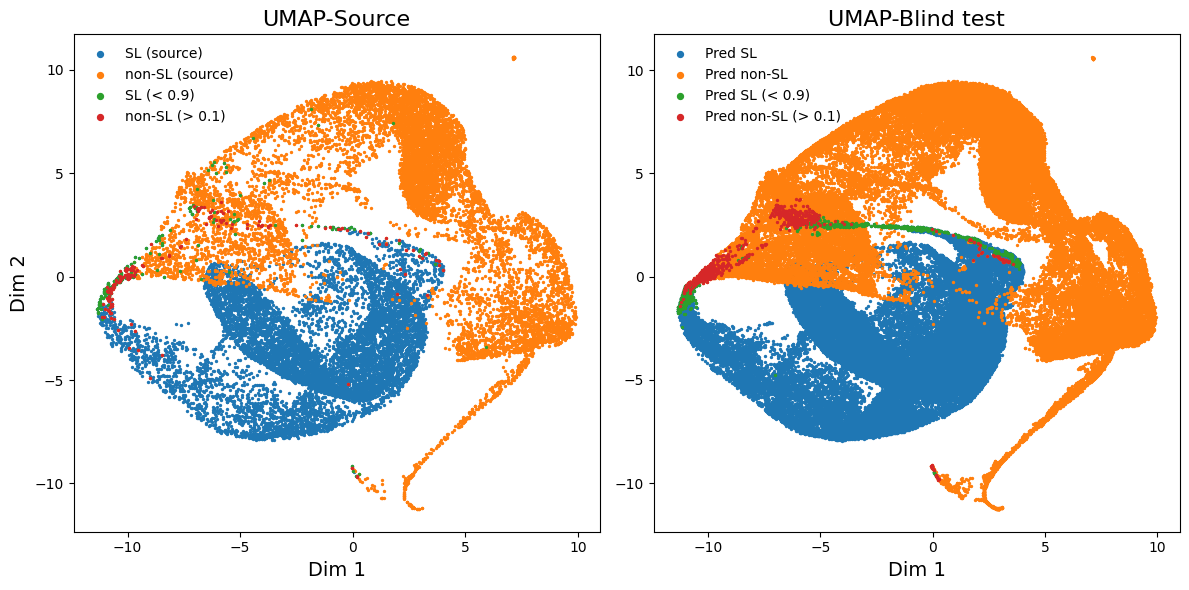

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].scatter(source_embs_sl[:,0], source_embs_sl[:,1], s=2, label='SL (source)')
axs[0].scatter(source_embs_nosl[:,0], source_embs_nosl[:,1], s=2, label='non-SL (source)')

axs[0].scatter(source_embs_sl[idx_sl_low, 0], source_embs_sl[idx_sl_low, 1], s=2, label='SL (< 0.9)')
axs[0].scatter(source_embs_nosl[idx_nosl_high, 0], source_embs_nosl[idx_nosl_high, 1], s=2, label='non-SL (> 0.1)')

axs[0].set_xlabel('Dim 1', fontsize=14)
axs[0].set_ylabel('Dim 2', fontsize=14)

axs[0].set_title('UMAP-Source', fontsize=16)
axs[0].legend(frameon=False, fontsize=10, markerscale=3, loc='upper left')

axs[1].scatter(blind_embs_sl[:, 0], blind_embs_sl[:, 1], s=2, label='Pred SL')
axs[1].scatter(blind_embs_nosl[:, 0], blind_embs_nosl[:, 1], s=2, label='Pred non-SL')

axs[1].scatter(blind_embs_sl[idx_sl_low_blind, 0], blind_embs_sl[idx_sl_low_blind, 1], s=2, label='Pred SL (< 0.9)')
axs[1].scatter(blind_embs_nosl[idx_nosl_high_blind, 0], blind_embs_nosl[idx_nosl_high_blind, 1], s=2, label='Pred non-SL (> 0.1)')


axs[1].set_xlabel('Dim 1', fontsize=14)
# axs[0].set_ylabel('Dim 2', fontsize=14)

axs[1].set_title('UMAP-Blind test', fontsize=16)
axs[1].legend(frameon=False, fontsize=10, markerscale=3, loc='upper left')

plt.tight_layout()
# plt.savefig('plots/umap.pdf')